# Hebbian Learning

In [2]:
import numpy as np  # Fast math and arrays
import matplotlib.pyplot as plt  # Displays
import matplotlib.colors as colors  # colors
import matplotlib.cm as cmx  # Colormaps
from math import pi
from math import sin
%matplotlib inline  

## Classic conditioning with Hebb rule

This is a model of the classic experiment whereby the eyeblink response a rabbit, normally elicited by _unconditioned stimulus_ of an air puff,  becomes a _conditioned response_ to a the _conditioned stimulus_ of a tone. 

First, the network setup

In [3]:
tone = 1
swab = 1
blink = 1

no_tone = 0
no_swab = 0
no_blink = 0

x_tone = 0
x_swab = 0
y_blink = 0

w_tb = 0
w_pb = 1

eta = 0.025
gamma = 4

p_conditioning = [tone, swab] 
p_test = [tone, no_swab] 


Then, the simulations:

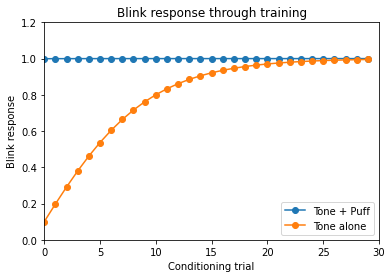

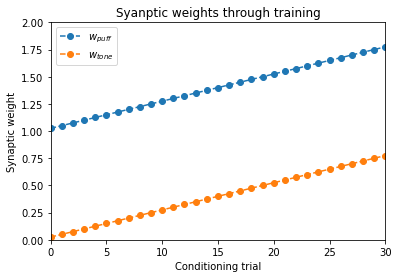

In [4]:
# Conditioning network


def set_inputs(p):
    """Sets the input"""
    global x_tone
    global x_swab
    
    x_tone = p[0]
    x_swab = p[1]

def activation():
    """Calculates activation"""
    global y_blink
    y_blink = np.tanh(gamma * (w_tb * x_tone + w_pb * x_swab))
    
def hebb():
    """Updates synaptic weights"""
    global w_pb
    global w_tb
    w_pb += eta * x_swab * y_blink
    w_tb += eta * x_tone * y_blink
    
train = []
test = []
w_pb_history = []
w_tb_history = []

def hebb_train(n = 30):
    """Conditioning paradigm"""
    for j in range(n):
        set_inputs(p_conditioning)
        activation()
        train.append(y_blink)
        
        hebb()
        
        set_inputs(p_test)
        activation()
        test.append(y_blink)
        
        w_pb_history.append(w_pb)
        w_tb_history.append(w_tb)


hebb_train()
plt.plot(train, "o-")
plt.plot(test, "o-")
plt.xlabel("Conditioning trial")
plt.ylabel("Blink response")
plt.title("Blink response through training")
plt.legend(["Tone + Puff", "Tone alone"], loc="best")
plt.axis([0, 30, 0, 1.2])
plt.show()


hebb_train()
plt.plot(w_pb_history, "o--")
plt.plot(w_tb_history, "o--")
plt.xlabel("Conditioning trial")
plt.ylabel("Synaptic weight")
plt.title("Syanptic weights through training")
plt.legend([r"$w_{puff}$", r"$w_{tone}$"], loc="best")
plt.axis([0, 30, 0, 2.0])
plt.show()

## Oja's rule

Oja's rule essentially adapts the weight matrix to extract the principal component of a number of vectors. Oja's rule is expressed as:

$$\Delta \mathbf{W} = \eta \mathbf{y} \times (\mathbf{x} - \mathbf{W} \mathbf{y}) $$

Here are the parameters

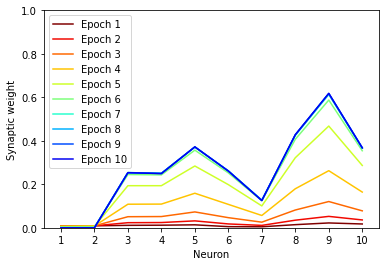

In [5]:
nx = 10
x = np.zeros((1, nx))
w = np.random.random(x.shape)/100
y = 0.0
eta = 0.05


def generate_patterns(n=6):
    """Generates binary patterns"""
    patterns = []
    scale = np.array(np.arange(0.5, 2.0, 1.5/nx))
    scale = scale.reshape((1, nx))
    for i in range(n):
        p = np.random.random(x.shape)
        p *= scale
        p = np.round(p)
        patterns.append(p)
    return patterns

def set_inputs(p):
    global x
    x = np.array(p).reshape((1, nx))

def calculate_response(p):
    global y
    set_inputs(p)
    y = activation()
    return y

def activation():
    return x.dot(w.T)

w_history = []

def oja(epochs=200):
    """Oja's rule"""
    global w, y
    for i in np.arange(epochs):
        for p in patterns:
            y = calculate_response(p)
            dw = eta * y * (x - w * y)
            w = w + dw
        w_history.append(w)


jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin = 0, vmax = 10)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

patterns = generate_patterns()
oja(10)
#print w_history
for i in range(10):
    plt.plot(w_history[i].tolist()[0], color = scalarMap.to_rgba(10-i))
plt.ylabel("Synaptic weight")
plt.xlabel("Neuron")
plt.axis([-0.5, nx - 1/2, 0, 1])
plt.xticks(range(nx), ["%s" % (x+1) for x in range(nx)])
plt.legend(["Epoch %s" % (x+1) for x in range(10)], loc="best")
plt.show()

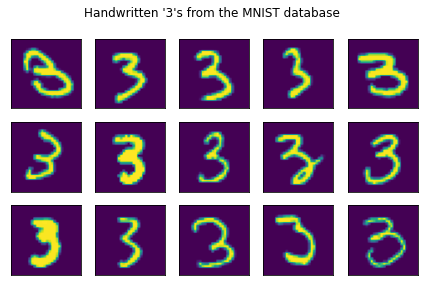

In [6]:
n_examples = 15
examples = []
target = 3
with open('mnist_train.csv') as mnist:
    while len(examples) < n_examples:
        line = mnist.readline().split(",")
        line = [int(x) for x in line]
        if line[0] == target:
            examples.append(line)
            
fig, axs = plt.subplots(3, 5, figsize=(6,4))
for i, example in enumerate(examples):
    mat = np.array(example[1:])
    mat = mat.reshape((28, 28))/256
    axs.flat[i].imshow(mat)
    axs.flat[i].set_xticks([])
    axs.flat[i].set_yticks([])
    
fig.suptitle("Handwritten '%d's from the MNIST database" % (target,))
fig.tight_layout()
plt.savefig("figures/mnist_example_3s.png")
plt.show()

Now, we apply Oja's rule repeatedly to these 15 examples, and examine the learned weights i the synaptic matrix $W$

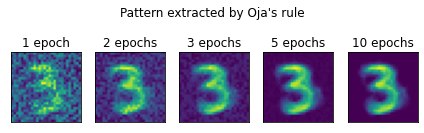

In [7]:
nx = 28**2
x = np.zeros((1, nx))
w = np.random.random(x.shape)/100
y = 0.0
eta = 0.001

def set_inputs(p):
    global x
    x = np.array(p).reshape((1, nx))

def calculate_response(p):
    global y
    set_inputs(p)
    y = activation()
    return y

def activation():
    return x.dot(w.T)

w_history = []

def oja(epochs=200):
    """Oja's rule"""
    global w, x, y
    for i in np.arange(epochs):
        for ex in examples:
            p = np.array(ex[1:])
            y = calculate_response(p/256)
            dw = eta * y * (x - w * y)
            w = w + dw
        w_history.append(w)

        
fig, axs = plt.subplots(1, 5, figsize=(6, 2))
for i, n in enumerate([1, 2, 3, 5, 10]):
    x = np.zeros((1, nx))
    w = np.random.random(x.shape)/100
    y = 0.0
    oja(n)
    
    axs.flat[i].imshow(w.reshape((28, 28)))
    axs.flat[i].set_xticks([])
    axs.flat[i].set_yticks([])
    end = ""
    if n > 1:
        end = "s"
    axs.flat[i].set_title("%d epoch%s" % (n, end))
fig.suptitle("Pattern extracted by Oja's rule")
fig.tight_layout()
plt.savefig("figures/oja.png")
plt.show()

## Contrastive Hebbian Learning

Contrastive Hebbian Learning (CHL) is an algorithm that can be used to perform supervised learning in a neural network. It unites the power of backpropagation with the plausibility of Hebbian learning, and is thus a favorite of researchers in computational neuroscience. In terms of power, Xie (2006) has shown that, under most conditions, CHL is actually equivalent to backpropagation. 

### "Learn" and "Unlearn" phases

CHL works by performing Hebbian updates in two distinct phases, which are indicated as the __Learn__ (+) or the __Unlearn__ (-) phases. Synapcti weights are updated according to the difference of the two phases:

$$
w_{i,j} \leftarrow w_{i,j} + \eta (y^+_i y^+_j - y^-_i y^-_j) 
$$

Where $y$ represents, as usual, the output of a neuron.

### Synchronous and Asynchronous Learning

In the canonical equation (above), the two terms $y^+_i y^+_j$ and $-y^-_i y^-_j$ are computed at different times but updated at the same moment. Because of this, the canonical form is called __synchronous__. This form is efficient but implausible, because it requires storing the products $y^+_i y^+_j$ and $-y^-_i y^-_j$ until the update is performed.

An more plausible alternative is to perform __asynchronous__  updates, with the product $y_i y_j$ because calculated and used immediately (just like in canonical Hebbian learning) and the sign of the update being dependent upon the phase.  

$$
w_{i,j} \leftarrow w_{i,j} +
\begin{cases}
 + \eta (y_i y_j) & \mathrm{if~phase~is "Learn"} \\
 - \eta (y_i y_j) & \mathrm{if~phase~is "Unlearn"} 
\end{cases}
$$

### Recurrent Connectivity 

Because of its very nature, CHL requires the network to be __recurrent__, that is, synaptic matrices that connect two adjacent layers both forward and backward.   

In turn, recurrent networks are intrinsically unstable, as require multiple passes to converge towards a stable solution. The number of passes is sometimes used as a proxy for response times or similar behavioral measures.

### The XOR Network

The CHL version of the XOR network is defined in these few lines of code. 

In [8]:
n_input  = 2
n_hidden  = 3
n_output = 1

eta = 0.5   # Learning rate. This is higher than usual.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

x    = np.zeros((1, n_input))                               # Input layer
h    = np.zeros((1, n_hidden))                              # Hidden layer
o    = np.zeros((1, n_output))                              # Output layer
w_xh = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
w_ho = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses
w_oh = (np.random.random((n_output, n_hidden)) / 5) - 0.1   # Second layer of synapses


Here are the functions that support the network

In [9]:
def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

def set_inputs(pattern):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(pattern).reshape((1,n_input))
    
def set_outputs(vals):
    """Sets the output variables"""
    global o
    o = vals

def target(val):
    """Desired response function, t(p)"""
    if  val == [0, 1] or val == [1, 0]:
        return np.array([[1.0]])
    else:
        return np.array([[0.0]])

def error(p1, p2):
    """Calculates the error function"""
    return 0.5 * np.sum(((p1 - p2) ** 2))

    
def propagate(clamped_output = False):
    """Spreads activation through a network"""
    global h
    global o
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w_xh) + np.dot(o, w_oh) 
    h = logistic(h_input)
    
    if not clamped_output:
        output_input = np.dot(h, w_ho)
        o = logistic(output_input)

        
def activation(clamped_output = False, convergence = 0.00001, max_cycles = 250):
    """Spreads activation through a network until it settles"""
    previous_h = np.copy(h)
    propagate(clamped_output)
    diff = error(previous_h, h)
    i = 1
    
    while diff > convergence and i < max_cycles:
        previous_h = np.copy(h)
        propagate(clamped_output)
        diff = error(previous_h, h)
        i += 1
    return i


def calculate_response(p):
    """Calculate the response for a given network's input"""
    set_inputs(p)
    activation(False)
    return np.sum(o)


def chl_pos():
    """Positive Hebbian update (unlearn)"""
    global w_xh, w_ho, w_oh
    w_xh += eta * (x.T.dot(h))
    w_ho += eta * (h.T.dot(o))
    w_oh += eta * (o.T.dot(h))
    
    
def chl_neg():
    """Negative Hebbian update (unlearn)"""
    global w_xh, w_ho, w_oh
    w_xh -= eta * (x.T.dot(h))
    w_ho -= eta * (h.T.dot(o))
    w_oh -= eta * (o.T.dot(h))


def asynchronous_chl(min_error = 0.001, max_epochs = 100, verbose=False):
    """Learns associations by means applying CHL asynchronously"""
    E = [min_error + 1]  ## Initial errir value > min_error
    epochs = 0
    #global o
    while E[-1] > min_error and epochs < max_epochs:
        e = 0.0
        for p in patterns:
            calculate_response(p)
            #set_inputs(p)
            #activation(False)
            e += error(target(p), o)
            if verbose:
                print([p, target(p), float(o), error(target(p), o)])
            chl_neg()
            
            set_inputs(p)
            set_outputs(target(p))
            activation(True)
            chl_pos()
            
        #print(w_ho)
        #print(e)
        E.append(e)
        epochs += 1
    return E[1:]

### Testing CHL on the XOR Problem

Here is a simple test of (asynchronous) CHL: Training a three-layer network to perform the XOR logical function.

In [10]:
x    = np.zeros((1, n_input))                               # Input layer
h    = np.zeros((1, n_hidden))                              # Hidden layer
o    = np.zeros((1, n_output))                              # Output layer
w_xh = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
w_ho = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses
w_oh = (np.random.random((n_output, n_hidden)) / 5) - 0.1   # Second layer of synapses

E = asynchronous_chl(min_error = 0.001, max_epochs = 5000, verbose=False)

And here is a plot of the error function and the network's learned outputs

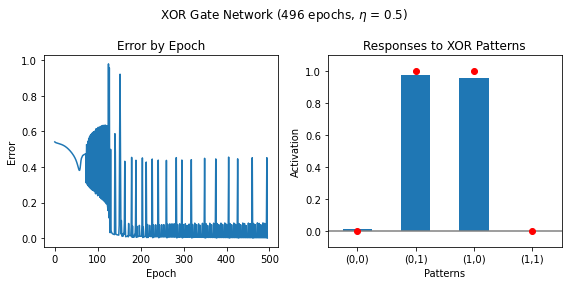

In [11]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

# Error by epoch

ax1.plot(E)
ax1.set_title("Error by Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Error")

## Plot the responses to the XOR patterns

y_end = [calculate_response(p) for p in patterns]
ax2.axis([-0.5, 3.5, -0.1, 1.1])
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax2.set_ylabel("Activation")
ax2.set_xlabel("Patterns")
ax2.bar(np.arange(4), y_end, 0.5)
ax2.hlines(xmin=-100, xmax=100, y=0, color="grey", linestyle="-")
ax2.plot(np.arange(4), [float(target(p)) for p in patterns], marker="o", color="red", linestyle="")
ax2.set_title("Responses to XOR Patterns")
fig.suptitle("XOR Gate Network (%d epochs, $\eta$ = %.1f)" % (len(E), eta))
fig.tight_layout()
plt.savefig("figures/xor_chl.png")
plt.show()

Like in Backprop, the hidden layer has learned how to separate the inputs.

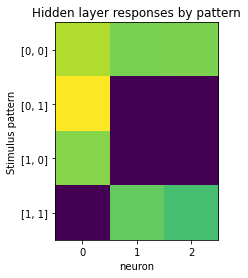

In [12]:
res = np.zeros((len(patterns), h.size))

for p in patterns:
    calculate_response(p)
    i = patterns.index(p) 
    res[i] = h

plt.imshow(res, interpolation = "none")
plt.title("Hidden layer responses by pattern")
plt.yticks(np.arange(4), patterns)
plt.ylabel("Stimulus pattern")
plt.xlabel("neuron")
plt.show()

## Relationship between CHL and Backpropagation

The following figure illustrates the relationship between CHL and Backprop.

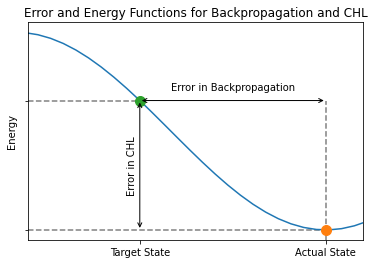

In [13]:
def f(x):
    return np.sin(2 * pi * x)

x = np.linspace(0, 1)

a = 0.45
t = 0.75

fig, ax = plt.subplots()
ax.axis([0.27, 0.81, -1.1, 1.1])
ax.plot(x, f(x))
ax.plot([t], [f(t)], "o", markersize=10)
ax.plot([a], [f(a)], "o", markersize=10)
ax.hlines(xmin=0, xmax=a, y=f(a), color="grey", linestyle='--')
ax.hlines(xmin=0, xmax=t, y=f(t), color="grey", linestyle='--')

ax.vlines(ymin=-1.1, ymax=f(a), x=t, color="grey", linestyle='--')
ax.annotate(text='', xy=(a,f(a)), xytext=(t,f(a)), arrowprops=dict(arrowstyle='<->'))
ax.annotate(text='', xy=(a,f(t)), xytext=(a,f(a)), arrowprops=dict(arrowstyle='<->'))

ax.text(s="Error in Backpropagation", x=(a+t)/2, y= f(a)+0.1, ha="center")
ax.text(s="Error in CHL", x=a - 0.02, y= (f(t) + f(a))/2, va="center", rotation=90)
ax.set_title("Error and Energy Functions for Backpropagation and CHL") 
ax.set_ylabel("Energy")
plt.xticks([a, t], labels=["Target State", "Actual State"])
plt.yticks([f(a), f(t)], labels=[])#labels=["$E_{Actual}$", "$E_{Target}$"])
plt.savefig("figures/backprop_vs_chl.png")
plt.show()